# Monetary Incentive Delay (MID) Task Analysis

This notebook analyzes reaction time (RT) data from the MID task, where participants respond to trials with different reward/punishment conditions. The code:
- Loads and cleans behavioral data
- Assigns trial types (e.g., Large_gain, Small_loss)
- Removes missed responses
- Visualizes RTs by trial type for all subjects and a specific subject (sub-1249)
- Performs statistical tests to compare RTs across conditions

## Setup
Import required libraries and configure plotting settings.

In [1]:
import os
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from natsort import natsorted
from scipy.io import loadmat
from scipy.stats import ttest_rel
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Set matplotlib parameters
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['figure.figsize'] = [8, 6]

## Load and Filter Outlier Data
Read the outlier runs file and filter out problematic runs. Create a subject-run identifier for matching.

In [3]:
sub_df = pd.read_csv('../../istart-mid/derivatives/OutlierRuns.tsv', sep='\t')
sub_df = sub_df[sub_df['outlier_run'] == False]
sub_df['sub_run'] = sub_df['Sub'] + '_' + sub_df['run'].astype(str)

## Load Behavioral Data
List all behavioral data files and display dataset information.

In [5]:
Mat_Beh_dir = '../../istart/Monetary_Incentive/data'
ML_EvFiles_list = natsorted([
    os.path.join(root, f) for root, _, files in os.walk(Mat_Beh_dir)
    for f in files if 'run' in f
])

print(f"Number of Subjects: {len([x for x in os.listdir(Mat_Beh_dir) if x.startswith('sub')])}")
print(f"Number of files: {len(ML_EvFiles_list)}")

Number of Subjects: 61
Number of files: 83


## Load and Process Run Conditions
Load trial conditions for runs 1 and 2, mapping numeric codes to descriptive trial types.

In [7]:
def load_run_conditions(run_num):
    run_cond = loadmat(f'{Mat_Beh_dir}/../timing/run{run_num}.mat')
    cond = run_cond['run']['cond'][0, 0].ravel()
    mapping = {
        '1': 'Large_gain', 1: 'Large_gain',
        '2': 'Large_loss', '3': 'Small_gain',
        '4': 'Small_loss', '5': 'Neutral'
    }
    return np.array([mapping.get(str(x), x) for x in cond])

run1, run2 = load_run_conditions(1), load_run_conditions(2)

## Process Behavioral Data
Load and structure data from .mat files into a DataFrame, assigning trial types based on run number.

In [9]:
data = []
for ML_EvFile in ML_EvFiles_list:
    sub = 'sub-' + re.search(r'sub-(.*?)/', ML_EvFile).group(1)
    run = re.search(r'run-(.*?)_out', ML_EvFile).group(1)
    
    mat = loadmat(ML_EvFile)
    mdata = mat['output']
    mdtype = mdata.dtype
    ndata = {n: mdata[n][0, 0] for n in mdtype.names}
    
    lens = [len(x[0]) for x in ndata.values()]
    if lens.count(lens[0]) == len(lens):
        df = pd.DataFrame(
            np.transpose(np.concatenate([ndata[c] for c in ndata])),
            columns=ndata.keys()
        )
        df['trial_type'] = run1[:len(df)] if run == '1' else run2
        df['sub'], df['run'] = sub, run
        data.append(df)

df = pd.concat(data, ignore_index=True)

## Clean Data
Remove missed responses (RT <= 0.01) and calculate the number of missed trials.

In [11]:
df = df[df['RT'] > 0.01]

misses = [
    len(tmp[(tmp['RT'] == 0) & (tmp['outcome'] == 0)])
    for sub in df['sub'].unique()
    for run in df[df['sub'] == sub]['run'].unique()
    for tmp in [df[(df['sub'] == sub) & (df['run'] == run)]]
]
print(f"Maximum missed trials: {np.max(misses)} (less than 20% of trials)")

Maximum missed trials: 0 (less than 20% of trials)


## Assign Trial Codes
Map trial types to numeric codes for analysis and ensure run is integer type.

In [13]:
df['Trial_code'] = df['trial_type'].map({
    'Large_loss': -2, 'Small_loss': -1, 'Neutral': 0,
    'Small_gain': 1, 'Large_gain': 2
})
df['run'] = df['run'].astype(int)

## Group Data for Analysis
Calculate median RTs by subject and trial type for downstream analysis.

In [15]:
group_df = df.groupby(['sub', 'trial_type']).median(numeric_only=True).reset_index()

## Visualize Individual Subject RTs
Create a bar plot of median RTs for subject sub-1249.

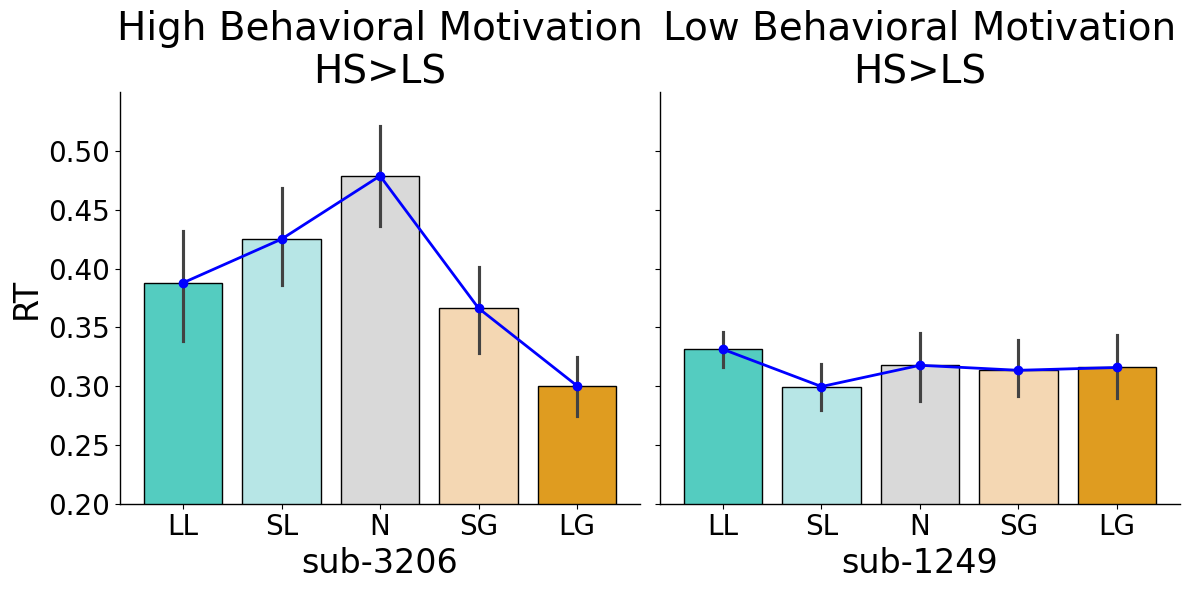

In [42]:
# Visualize RTs for two subjects in subplots
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12, 6))

# Define subjects and their titles
subjects = [('sub-3206', 'High Behavioral Motivation\nHS>LS'), ('sub-1249', 'Low Behavioral Motivation\nHS>LS')]
gradient_palette = ["#40E0D0", "#AFEEEE", "#D9D9D9", "#FFD8A8", "#FFA500"]

# X-tick labels mapping
tick_labels = ['LL', 'SL', 'N', 'SG', 'LG']

for ax, (sub_id, main_title) in zip([ax1, ax2], subjects):
    sub_df = df[df['sub'] == sub_id]
    
    # Bar plot
    g = sns.barplot(
        x='Trial_code', y='RT', data=sub_df,
        errorbar=('ci', 68), hue='Trial_code', palette=gradient_palette, legend=False, ax=ax
    )
    
    # Calculate mean RTs for trendline
    means = sub_df.groupby('Trial_code')['RT'].mean().reindex([-2, -1, 0, 1, 2])
    
    # Add trendline
    ax.plot(range(len(means)), means.values, color='blue', linewidth=2, marker='o')
    
    # Formatting
    ax.set_ylim(0.2, 0.55)
    ax.set_xticks(range(5))
    ax.set_xticklabels(tick_labels, fontsize=20)
    ax.set_yticks([0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5])
    ax.set_yticklabels([f'{x:.2f}' for x in ax.get_yticks()], fontsize=20)
    ax.set_xlabel(sub_id, fontsize=24)  # Use sub_id as x-axis label
    ax.set_ylabel('RT' if ax == ax1 else '', fontsize=24)
    ax.set_title(main_title, fontsize=28)
    for bar in ax.patches:
        bar.set_edgecolor("black")
        bar.set_linewidth(1)
    ax.spines[['top', 'right']].set_visible(False)
    ax.spines[['left', 'bottom']].set_color("black")
    ax.spines[['left', 'bottom']].set_linewidth(1)

plt.tight_layout()
plt.savefig('sub-3206-1249-RT.svg', format='svg')
plt.show()

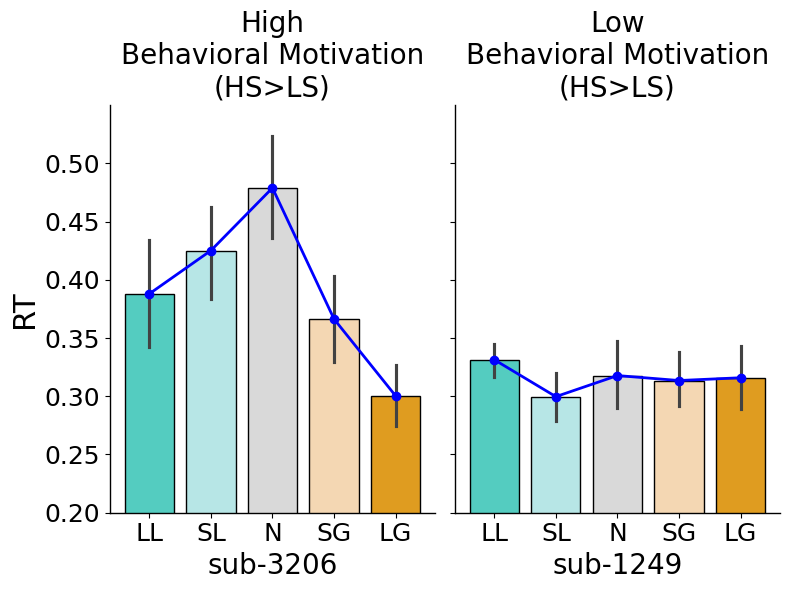

In [48]:
# Visualize RTs for two subjects in subplots
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(8, 6))  # narrowed width

# Define subjects and their titles
subjects = [('sub-3206', 'High\nBehavioral Motivation\n(HS>LS)'), ('sub-1249', 'Low\nBehavioral Motivation\n(HS>LS)')]
gradient_palette = ["#40E0D0", "#AFEEEE", "#D9D9D9", "#FFD8A8", "#FFA500"]

# X-tick labels mapping
tick_labels = ['LL', 'SL', 'N', 'SG', 'LG']

for ax, (sub_id, main_title) in zip([ax1, ax2], subjects):
    sub_df = df[df['sub'] == sub_id]
    
    # Bar plot
    g = sns.barplot(
        x='Trial_code', y='RT', data=sub_df,
        errorbar=('ci', 68), hue='Trial_code', palette=gradient_palette, legend=False, ax=ax
    )
    
    # Calculate mean RTs for trendline
    means = sub_df.groupby('Trial_code')['RT'].mean().reindex([-2, -1, 0, 1, 2])
    
    # Add trendline
    ax.plot(range(len(means)), means.values, color='blue', linewidth=2, marker='o')
    
    # Formatting
    ax.set_ylim(0.2, 0.55)
    ax.set_xticks(range(5))
    ax.set_xticklabels(tick_labels, fontsize=18)  # slightly reduced
    ax.set_yticks([0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5])
    ax.set_yticklabels([f'{x:.2f}' for x in ax.get_yticks()], fontsize=18)
    ax.set_xlabel(sub_id, fontsize=20)
    ax.set_ylabel('RT' if ax == ax1 else '', fontsize=22)
    ax.set_title(main_title, fontsize=20)
    for bar in ax.patches:
        bar.set_edgecolor("black")
        bar.set_linewidth(1)
    ax.spines[['top', 'right']].set_visible(False)
    ax.spines[['left', 'bottom']].set_color("black")
    ax.spines[['left', 'bottom']].set_linewidth(1)

# Tighten spacing without overlap
plt.subplots_adjust(wspace=0.2)
plt.tight_layout()
plt.savefig('sub-3206-1249-RT.svg', format='svg')
plt.show()


## Visualize Group RTs
Create a bar plot of median RTs by trial type across all subjects.

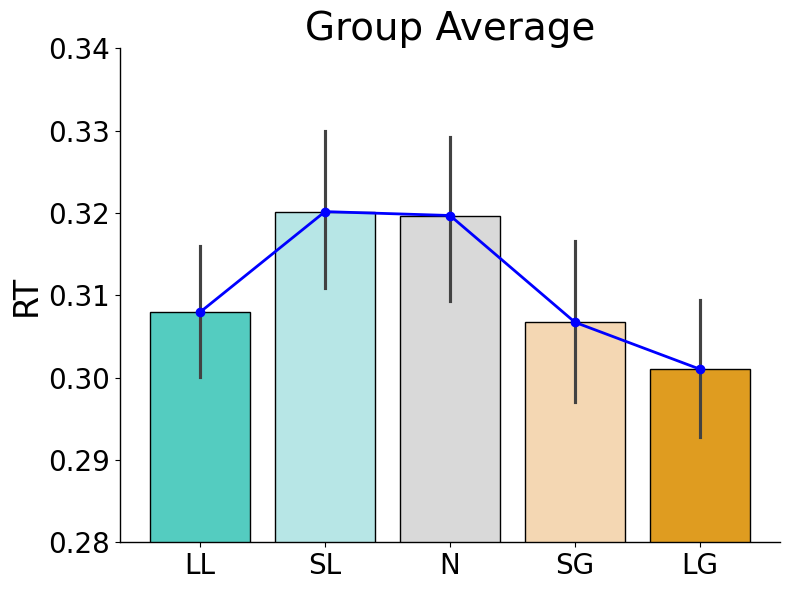

In [40]:
# Visualize group RTs
gradient_palette = ["#40E0D0", "#AFEEEE", "#D9D9D9", "#FFD8A8", "#FFA500"]
tick_labels = ['LL', 'SL', 'N', 'SG', 'LG']

g = sns.barplot(
    x='Trial_code', y='RT', data=group_df,
    errorbar=('ci', 68), hue='Trial_code', palette=gradient_palette, legend=False
)
#plt.yscale('log')  # Apply logarithmic scale
#plt.yticks([0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5])
#plt.gca().set_yticklabels([f'{x:.2f}' for x in plt.gca().get_yticks()], fontsize=20)
plt.xticks(range(5), tick_labels, fontsize=20)
plt.ylim(0.28, 0.34)
plt.yticks(fontsize=20)
plt.xlabel('', fontsize=24)
plt.ylabel('RT', fontsize=24)
plt.title('Group Average', fontsize=28)
for bar in g.patches:
    bar.set_edgecolor("black")
    bar.set_linewidth(1)
g.spines[['top', 'right']].set_visible(False)
g.spines[['left', 'bottom']].set_color("black")
g.spines[['left', 'bottom']].set_linewidth(1)

# Add trendline
means = group_df.groupby('Trial_code')['RT'].mean().reindex([-2, -1, 0, 1, 2])
plt.plot(range(len(means)), means.values, color='blue', linewidth=2, marker='o')

plt.tight_layout()
plt.savefig('group-RT.svg', format='svg')
plt.show()

## Statistical Tests
Perform paired t-tests to compare RTs between trial types (Large_gain vs. Neutral, Large_loss vs. Neutral).

In [50]:
import pandas as pd
import subprocess
import os

# Step 1: Read in the data
file_path = '~/Documents/Github/istart-mid-clean/code/total_df_n46.xlsx'
df = pd.read_excel(file_path)

# Step 2: Reshape to long format
df_long = df.melt(
    id_vars='Sub', 
    value_vars=['Beh_LG', 'Beh_SG', 'Beh_N', 'Beh_SL', 'Beh_LL'],
    var_name='Condition',
    value_name='Value'
)

# Step 3: Clean up condition labels
condition_map = {
    'Beh_LG': 'Large Gain',
    'Beh_SG': 'Small Gain',
    'Beh_N': 'Neutral',
    'Beh_SL': 'Small Loss',
    'Beh_LL': 'Large Loss'
}
df_long['Condition'] = df_long['Condition'].map(condition_map)

# First run the Python-only ANOVA for reference
from statsmodels.stats.anova import AnovaRM
aovrm = AnovaRM(data=df_long, depvar='Value', subject='Sub', within=['Condition'])
aovrm_results = aovrm.fit()
print("\nPython Repeated Measures ANOVA Results:\n")
print(aovrm_results)

# Save the long format data to a CSV file
csv_path = 'long_format_data.csv'
df_long.to_csv(csv_path, index=False)

# Create an R script file
r_script_path = 'run_emmeans_analysis.R'
with open(r_script_path, 'w') as f:
    f.write("""
# Load required packages
library(emmeans)

# Read the data
data <- read.csv('long_format_data.csv')

# Make Condition a factor with the correct levels
data$Condition <- factor(data$Condition, 
                         levels = c("Large Gain", "Small Gain", "Neutral", "Small Loss", "Large Loss"))
data$Sub <- factor(data$Sub)  # Ensure Sub is treated as a factor

# Run the repeated measures ANOVA
anova_results <- aov(Value ~ Condition + Error(Sub/Condition), data = data)

# Print the ANOVA results
cat("\\nR ANOVA Results:\\n")
print(summary(anova_results))

# Compute emmeans for the model
emm <- emmeans(anova_results, ~ Condition)

# Compute all pairwise comparisons
pairwise_comparisons <- contrast(emm, method = "pairwise", adjust = "tukey")

# Print all pairwise comparisons
cat("\\nR Pairwise Comparisons:\\n")
pairwise_summary <- summary(pairwise_comparisons)
print(pairwise_summary)

# Save the results to a CSV file
write.csv(as.data.frame(pairwise_summary), 'r_pairwise_results.csv', row.names = FALSE)
""")

# Run the R script
try:
    result = subprocess.run(['Rscript', r_script_path], 
                           capture_output=True, text=True, check=True)
    print(result.stdout)
    if result.stderr:
        print("R warnings/errors:", result.stderr)
except subprocess.CalledProcessError as e:
    print("Error running R script:", e)
    print("R output:", e.stdout)
    print("R error:", e.stderr)
    
# Read the results back into Python
try:
    if os.path.exists('r_pairwise_results.csv'):
        r_results = pd.read_csv('r_pairwise_results.csv')
        print("\nR pairwise results loaded into Python:\n")
        print(r_results)
    else:
        print("R result file not found.")
except Exception as e:
    print("Error reading R results:", e)


Python Repeated Measures ANOVA Results:

                 Anova
          F Value Num DF  Den DF  Pr > F
----------------------------------------
Condition  5.0219 4.0000 180.0000 0.0007


R ANOVA Results:

Error: Sub
          Df Sum Sq Mean Sq F value Pr(>F)
Residuals 45 0.5617 0.01248               

Error: Sub:Condition
           Df  Sum Sq  Mean Sq F value   Pr(>F)    
Condition   4 0.01646 0.004116   5.022 0.000735 ***
Residuals 180 0.14752 0.000820                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R Pairwise Comparisons:
 contrast                 estimate      SE  df t.ratio p.value
 Large Gain - Small Gain -0.007629 0.00597 180  -1.278  0.7050
 Large Gain - Neutral    -0.021040 0.00597 180  -3.525  0.0048
 Large Gain - Small Loss -0.016521 0.00597 180  -2.768  0.0484
 Large Gain - Large Loss -0.000424 0.00597 180  -0.071  1.0000
 Small Gain - Neutral    -0.013411 0.00597 180  -2.247  0.1675
 Small Gain - Small Loss -0.008892 0.00597 180 

## Correlation Heatmap
Create a correlation heatmap for selected variables (`comp_RS`, `score_teps_ant`, `V_beta`, `LG_N_new`, `LL_N_new`), showing Pearson correlations in a lower triangle format, styled to match previous plots.

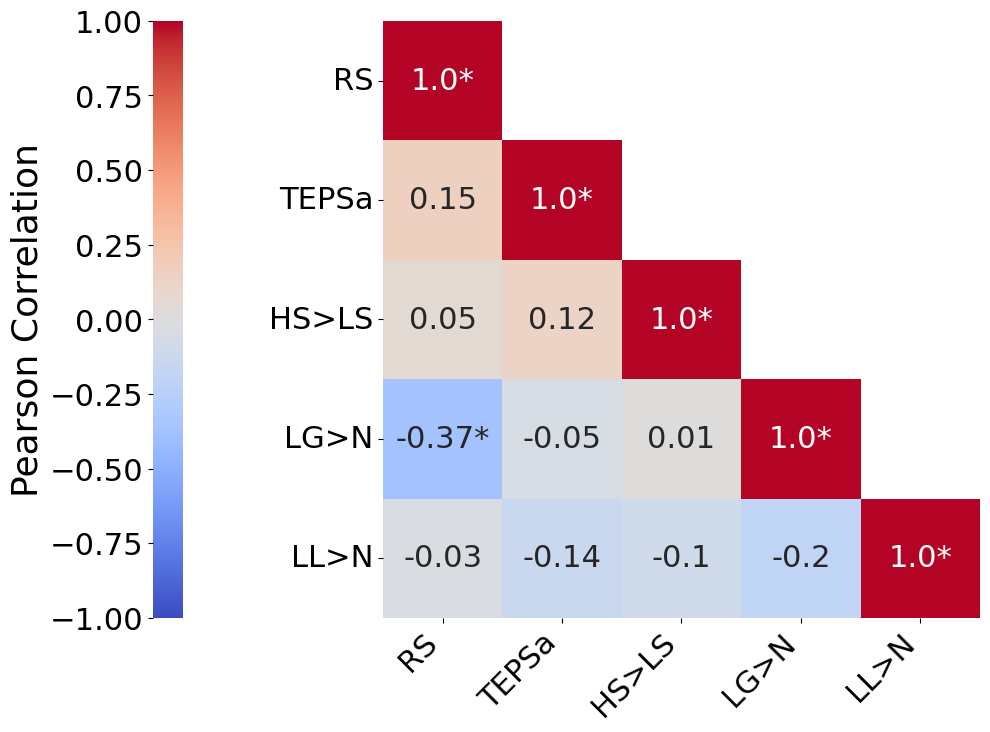

In [53]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Load the data
file_path = '~/Documents/Github/istart-mid-clean/code/total_df_n46.xlsx'
df = pd.read_excel(file_path)

# Map original column names to new display names
name_mapping = {
    'comp_RS': 'RS',
    'score_teps_ant': 'TEPSa',
    'V_beta': 'HS>LS',
    'LG_N_new': 'LG>N',
    'LL_N_new': 'LL>N'
}

corr_cols = list(name_mapping.keys())
corr_df = df[corr_cols].dropna()

# Compute correlation matrix and p-values
cormat = corr_df.corr(method='pearson').round(2)
pvals = pd.DataFrame(np.zeros_like(cormat), index=cormat.index, columns=cormat.columns)

for i in range(len(corr_cols)):
    for j in range(len(corr_cols)):
        _, pvals.iloc[i, j] = pearsonr(corr_df[corr_cols[i]], corr_df[corr_cols[j]])

# Annotate all cells, including diagonal
annot = cormat.copy().astype(str)
annot[pvals < 0.05] = annot[pvals < 0.05] + '*'

# Rename for plotting
cormat.columns = [name_mapping[col] for col in cormat.columns]
cormat.index = [name_mapping[col] for col in cormat.index]
annot.columns = cormat.columns
annot.index = cormat.index

# Mask upper triangle only
mask = np.triu(np.ones_like(cormat, dtype=bool), k=1)

# Set up figure
fig, ax = plt.subplots(figsize=(10, 8))

# Create separate colorbar axis with more padding
divider = make_axes_locatable(ax)
cax = divider.append_axes("left", size="5%", pad=2)

# Plot heatmap
g = sns.heatmap(
    cormat, mask=mask, annot=annot, fmt='', cmap='coolwarm',
    vmin=-1, vmax=1, center=0, square=True,
    annot_kws={'size': 22},  # slightly increased
    cbar_ax=cax, cbar_kws={'label': 'Pearson Correlation'},
    ax=ax
)

# Tick labels
tick_fontsize = 22
g.set_xticklabels(g.get_xticklabels(), rotation=45, ha='right', fontsize=tick_fontsize)
g.set_yticklabels(g.get_yticklabels(), rotation=0, ha='right', fontsize=tick_fontsize)

# Colorbar styling
cax.yaxis.set_label_position('left')
cax.yaxis.set_ticks_position('left')
cax.yaxis.label.set_size(26)
cax.tick_params(labelsize=tick_fontsize)  # match tick font size to heatmap

# Remove spines
for spine in g.spines.values():
    spine.set_visible(False)

plt.tight_layout()
plt.savefig('correlation_heatmap.svg', format='svg', bbox_inches='tight')
plt.show()



## Scatterplot of Behavioral Motivation vs. Reward Sensitivity by TEPSa
Create a scatterplot of `V_beta` (Behavioral Motivation) vs. `comp_RS` (Reward Sensitivity), colored by `teps_ant_split`, with regression lines, styled to match previous plots.

Created teps_ant_split successfully.

low group size before regression: 23
Added regression line for low

high group size before regression: 23
Added regression line for high


/var/folders/m6/p7f91dqd37d_mdjnjbx6xdy80000gn/T/ipykernel_30935/2252522159.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(g.get_xticklabels(), fontsize=20)
/var/folders/m6/p7f91dqd37d_mdjnjbx6xdy80000gn/T/ipykernel_30935/2252522159.py:60: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_yticklabels([f'{x:.2f}' for x in g.get_yticks()], fontsize=20)


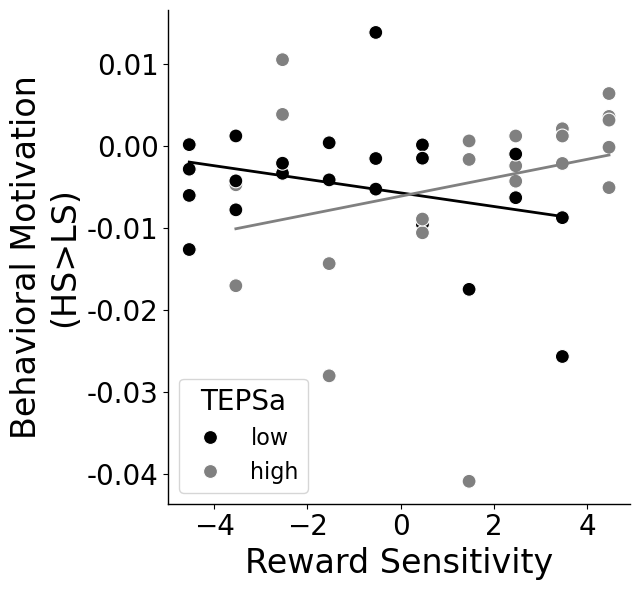


Linear Model Summary:
                            OLS Regression Results                            
Dep. Variable:                 V_beta   R-squared:                       0.225
Model:                            OLS   Adj. R-squared:                  0.149
Method:                 Least Squares   F-statistic:                     2.973
Date:                Wed, 16 Apr 2025   Prob (F-statistic):             0.0303
Time:                        16:23:51   Log-Likelihood:                 154.96
No. Observations:                  46   AIC:                            -299.9
Df Residuals:                      41   BIC:                            -290.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Inter

In [59]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

# Load the data
file_path = '~/Documents/Github/istart-mid-clean/code/total_df_n46.xlsx'
df = pd.read_excel(file_path)

# Drop rows with missing comp_RS or V_beta (none expected)
df_plot = df[['comp_RS', 'V_beta', 'score_teps_ant']].dropna().copy()

if df_plot.empty:
    print("Error: No valid data after dropping missing values. Cannot create plot.")
else:
    # Create teps_ant_split
    if 'teps_ant_split' not in df_plot.columns:
        if df_plot['score_teps_ant'].isna().all():
            print("Error: 'score_teps_ant' contains all NaN. Cannot create teps_ant_split.")
            df_plot['teps_ant_split'] = 'All'
        else:
            try:
                df_plot['teps_ant_split'] = pd.qcut(df_plot['score_teps_ant'], 2, labels=['low', 'high'])
                print("Created teps_ant_split successfully.")
            except ValueError as e:
                print(f"Error creating teps_ant_split: {e}. Using single group.")
                df_plot['teps_ant_split'] = 'All'

    # Create scatterplot
    plt.figure(figsize=(6.5, 6))
    g = sns.scatterplot(
        x='comp_RS', y='V_beta', hue='teps_ant_split', style='teps_ant_split',
        data=df_plot, palette=['black', 'gray'], markers=['o', 'o'], s=100
    )

    # Add regression lines without shaded error regions
    for group in ['low', 'high']:
        group_df = df_plot[df_plot['teps_ant_split'] == group]
        print(f"\n{group} group size before regression: {len(group_df)}")
        if len(group_df) >= 2:
            try:
                sns.regplot(
                    x='comp_RS', y='V_beta', data=group_df,
                    scatter=False, color='black' if group == 'low' else 'gray',
                    line_kws={'linestyle': 'solid', 'linewidth': 2},
                    ci=None,
                    ax=g
                )
                print(f"Added regression line for {group}")
            except Exception as e:
                print(f"Error adding regression line for {group}: {e}")
        else:
            print(f"Warning: Insufficient data for {group} regression line (n={len(group_df)}).")

    # Formatting
    plt.xlabel('Reward Sensitivity', fontsize=24)
    plt.ylabel('Behavioral Motivation\n(HS>LS)', fontsize=24)
    plt.title('', fontsize=28)
    g.set_xticklabels(g.get_xticklabels(), fontsize=20)
    g.set_yticklabels([f'{x:.2f}' for x in g.get_yticks()], fontsize=20)
    g.legend(title='TEPSa', fontsize=16, title_fontsize=20, loc='lower left')

    # Remove spines and grid
    g.spines[['top', 'right']].set_visible(False)
    g.spines[['left', 'bottom']].set_color('black')
    g.spines[['left', 'bottom']].set_linewidth(1)
    g.set_facecolor('white')
    g.grid(False)

    plt.tight_layout()
    plt.savefig('scatter_teps_rs.svg', format='svg')
    plt.show()

# Run linear model
print("\nLinear Model Summary:")
model = smf.ols('V_beta ~ score_teps_con + comp_RS * score_teps_ant', data=df).fit()
print(model.summary())

## Visualize Group Z-Statistics
Create a bar plot of average Z-statistics by trial type across all subjects, formatted to match the group and individual RT plots. The plot uses a logarithmic y-axis to emphasize differences, with x-tick labels `LL, SL, N, SG, LG` for trial types (Large Loss, Small Loss, Neutral, Small Gain, Large Gain).

/var/folders/m6/p7f91dqd37d_mdjnjbx6xdy80000gn/T/ipykernel_30935/1253194176.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels([f'{x:.2f}' for x in plt.gca().get_yticks()], fontsize=20)


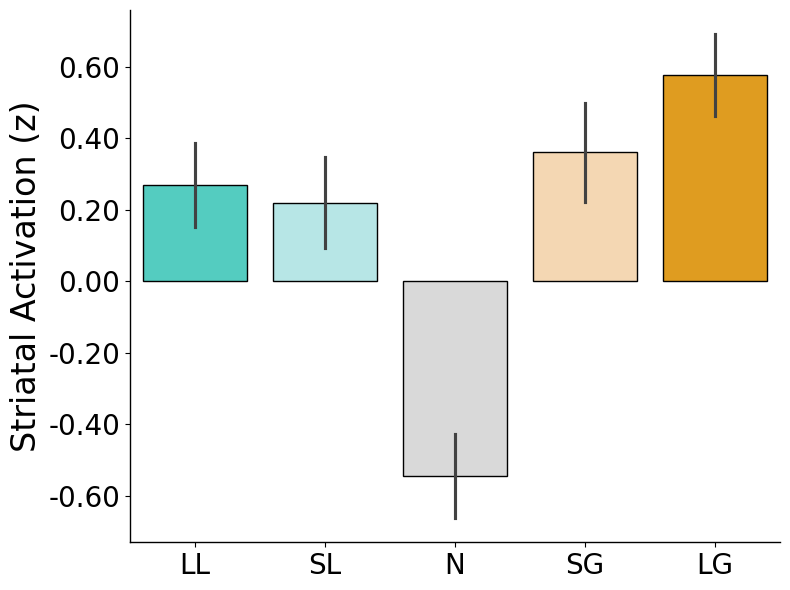

In [61]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the data
file_path = '~/Documents/Github/istart-mid-clean/code/total_df_n46.xlsx'
df = pd.read_excel(file_path)

# Filter relevant columns
columns_of_interest = ['zstat_ACT_VS_LargeLoss', 'zstat_ACT_VS_SmallLoss', 'zstat_ACT_VS_Neut', 
                       'zstat_ACT_VS_SmallGain', 'zstat_ACT_VS_LargeGain']

# Reshape the data for seaborn plotting
df_melted = df[columns_of_interest].melt(var_name='Condition', value_name='Z-stat')

# Define condition order and labels
condition_order = ['zstat_ACT_VS_LargeLoss', 'zstat_ACT_VS_SmallLoss', 'zstat_ACT_VS_Neut', 
                   'zstat_ACT_VS_SmallGain', 'zstat_ACT_VS_LargeGain']
tick_labels = ['LL', 'SL', 'N', 'SG', 'LG']
gradient_palette = ["#40E0D0", "#AFEEEE", "#D9D9D9", "#FFD8A8", "#FFA500"]

# Create bar plot
g = sns.barplot(
    x='Condition', y='Z-stat', data=df_melted, order=condition_order,
    palette=gradient_palette, errorbar='se'
)

# Apply linear scale and formatting
plt.gca().set_yticklabels([f'{x:.2f}' for x in plt.gca().get_yticks()], fontsize=20)
plt.xticks(range(5), tick_labels, fontsize=20)
plt.xlabel('', fontsize=24)
plt.ylabel('Striatal Activation (z)', fontsize=24)

# Add trendline
#means = df_melted.groupby('Condition')['Z-stat'].mean().reindex(condition_order)
#plt.plot(range(len(means)), means.values, color='blue', linewidth=2, marker='o')

# Additional formatting
for bar in g.patches:
    bar.set_edgecolor("black")
    bar.set_linewidth(1)
g.spines[['top', 'right']].set_visible(False)
g.spines[['left', 'bottom']].set_color("black")
g.spines[['left', 'bottom']].set_linewidth(1)

plt.tight_layout()
plt.savefig('group-Zstat.svg', format='svg')
plt.show()